<a href="https://colab.research.google.com/github/Henchen99/BEng-Project/blob/main/Time_series_forecasting/Redo_TOU_predict_1_month_march_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Forecasting For 1 Month In March 2020

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# pip install pmdarima

In [ ]:
# pip install forecast_tools

In [ ]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.style as style
from matplotlib import pyplot
from pandas.plotting import lag_plot

import datetime as dt
import matplotlib.dates as md
from datetime import date, time

# import statsmodels as sm
# import statsmodels.api as smapi
# from statsmodels.tsa.seasonal import seasonal_decompose

# # import warnings
# # warnings.filterwarnings('ignore')

# from forecast_tools.baseline import Naive1, Drift, SNaive, Average, baseline_estimators
# from forecast_tools.metrics import coverage, mean_absolute_percentage_error

# from fbprophet import Prophet
# from fbprophet.plot import plot_plotly, plot_components_plotly
# from fbprophet.diagnostics import cross_validation
# from fbprophet.diagnostics import performance_metrics
# from fbprophet.plot import plot_cross_validation_metric

# from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# from math import sqrt

# from sklearn.svm import SVR

# from statsmodels.tsa.stattools import adfuller
# from statsmodels.tsa.stattools import acf, pacf

# from statsmodels.tsa.arima.model import ARIMA
# from pmdarima import auto_arima

# from sklearn.preprocessing import MinMaxScaler
# from keras.preprocessing.sequence import TimeseriesGenerator
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM
# from keras.layers import Dropout

In [ ]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

### Import data

In [ ]:
usecol=['date','price']
# data = pd.read_csv('/content/drive/MyDrive/forecasting/march_2020_training.csv', index_col = 'date', usecols=usecol, parse_dates=True)
data = pd.read_csv('/content/drive/MyDrive/forecasting/TOU-November-2018.csv', index_col = 'date', usecols=usecol, parse_dates=True,dayfirst=True)
#data = pd.read_csv('/content/drive/MyDrive/forecasting/TOU-October-2019_presentation.csv', index_col = 'date', usecols=usecol, parse_dates=True,dayfirst=True)
#data = pd.read_csv('october_2018_training.csv', index_col = 'date', parse_dates=True)
#data = pd.read_csv('csv_agile_C_London.csv', index_col = 'date', parse_dates=True)
#data = pd.read_csv('TOU-November-2018.csv', index_col = 'date', parse_dates=True,dayfirst=True)

# parse dates = True allows pandas to know that it is dealing with dates
#data.index.freq = '30t'
#data.index = data.index.to_period('30t')
print(data.index.dtype)
print(data.shape)

datetime64[ns]
(1441, 1)


In [ ]:
data

,price
date,
2019-11-09 00:00:00,9.87
2019-11-09 00:30:00,10.08
2019-11-09 01:00:00,8.82
2019-11-09 01:30:00,8.82
2019-11-09 02:00:00,9.66
...,...
2019-12-08 22:00:00,6.51
2019-12-08 22:30:00,5.88
2019-12-08 23:00:00,3.15


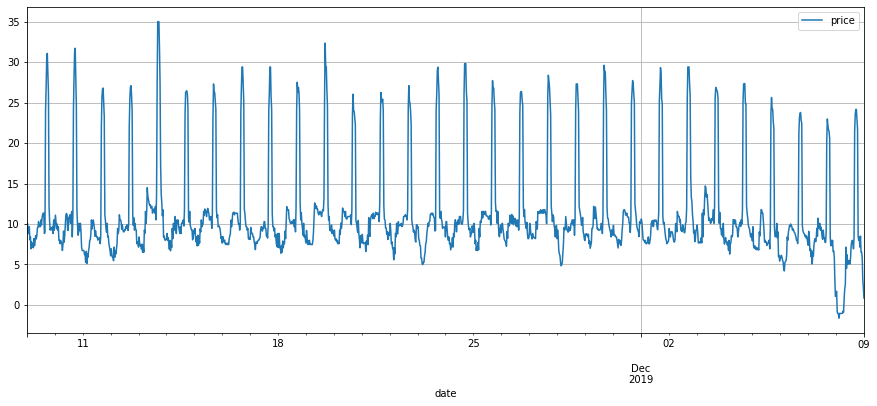

In [ ]:

ax=data.plot(figsize=(15, 6))
ax.grid()

## Check for stationarity

Time series forecasting there are many assumptions that are needed, these model assumptions are violated in time series by the addition of time-dependent values such as trend, seasonality etc. and will lead to poor, inaccurate forecasts <br><br>
Time series are stationary if they do not have trend or seasonal effects<br>
<b>Trend:</b> Describes movment of data values at regular intervals e.g. movement of data moving up over time is an upward trend <br>
<b>Seasonality:</b> Continues trend that repeats itself after a fixed intervals of time<br><br>
Linear regression model needs to prepare data by a degree of differencing so it is not stationary (remove trend and seasonal patterns that will negatively affect the regression model) 


Stationarity is decided on 3 criteria:<br>
1. it should have constant mean 
2. It should have constant variance
3. Auto covariance does not depend on time (relationship between any 2 values at a certain amount of time)<br><br>
In a non-stationary series, these properties are dependent on time.

In [ ]:
price = data['price']
price

date
2019-11-09 00:00:00     9.87
2019-11-09 00:30:00    10.08
2019-11-09 01:00:00     8.82
2019-11-09 01:30:00     8.82
2019-11-09 02:00:00     9.66
                       ...  
2019-12-08 22:00:00     6.51
2019-12-08 22:30:00     5.88
2019-12-08 23:00:00     3.15
2019-12-08 23:30:00     2.10
2019-12-09 00:00:00     0.84
Name: price, Length: 1441, dtype: float64

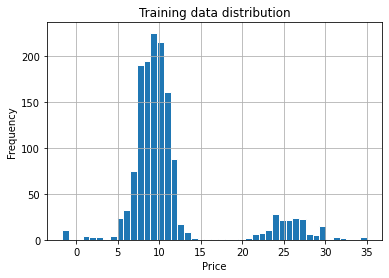

In [ ]:
ax=plt.hist(price, bins=45, edgecolor='white', linewidth=1)
plt.title('Training data distribution')
plt.ylabel('Frequency')
plt.xlabel('Price');
plt.grid()

Can see it is basically gaussianlly distributed with a long tail

### Augmented Dickey-Fuller test

It is a statistical test called a unit root test.
Unit root tests show how strongly a time series is defined by trend.

To perform this test, we need do hypothesis testing:<br><br>
Null Hypothesis (H0): series is non stationary or has a series unit root<br><br>
Alternate Hypothesis (H1): Series is stationary or has no unit root<br><br>
Result is determined using p-value from test, we will try, a critical value of 1%, 5%, 10% which are the common values

In [ ]:
# result = adfuller(price, autolag ='AIC')
# print('ADF Statistic: %f' % result[0])
# print('p-value: %f' % result[1])
# print('Critical Values:')
# for key, value in result[4].items():
# 	print('\t%s: %.3f' % (key, value))

In [ ]:
def adfuller_test(price):
    result=adfuller(price)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [ ]:
adfuller_test(data['price'])

ADF Test Statistic : -10.063941084473518
p-value : 1.3112679189575847e-17
#Lags Used : 24
Number of Observations Used : 1416
ADF Statistic: -10.063941
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


### Rolling statistics test

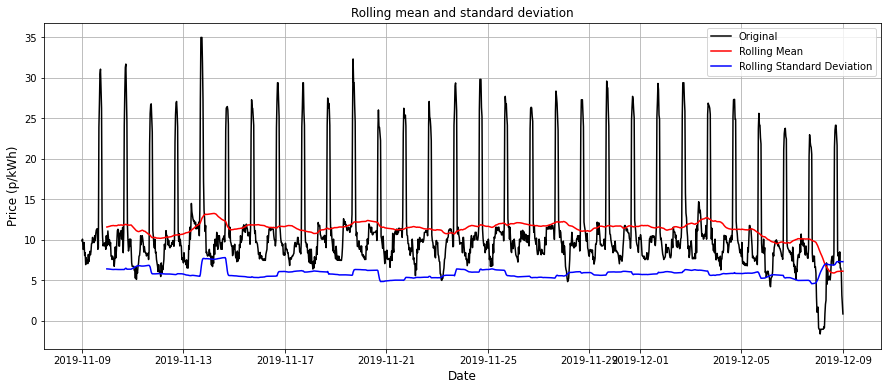

In [ ]:
rmean1=price.rolling(window=48).mean()
rstd1=price.rolling(window=48).std()
#print(rmean1,rstd1)
plt.figure(figsize=(15,6))
orig=plt.plot(price , color='black',label='Original')
mean= plt.plot(rmean1 , color='red',label='Rolling Mean')
std=plt.plot(rstd1,color='blue',label = 'Rolling Standard Deviation')
plt.legend(loc='best')
plt.title("Rolling mean and standard deviation")
plt.ylabel("Price (p/kWh)", fontsize=12)
plt.xlabel("Date", fontsize=12)
plt.grid()
plt.show(block=False)

#### Observations

<b>Augmented Dickey-Fuller test </b><br>
The result shows that the test statistic is -10.1 which is less than the critical values at all percentages (1%, 5%, 10%). Therefore we can conclude from there that the data is stationary. <br><br>
<b>Rolling Statistics Test</b><br>
This gives us a visual representation of the dataset. We can see that the rolling mean and standard deviation ar constant so the data is stationary

# Baseline Forecasts

In [ ]:
def preds_as_series(data, preds):
    '''
    Helper function for plotting predictions.
    Converts a numpy array of predictions to a 
    pandas.DataFrame with datetimeindex
    
    Parameters
    -----
    preds - numpy.array, vector of predictions
    start - start date of the time series
    freq - the frequency of the time series e.g 'MS' or 'D'
    '''
    start = pd.date_range(start=data.index.max(), periods=2, freq=data.index.freq).max()
    idx = pd.date_range(start=start, periods=len(preds), freq=data.index.freq)
    return pd.DataFrame(preds, index=idx)

In [ ]:
data_length = data.shape[0]
split70 = round(data_length*0.75)
train = data.iloc[:split70]
test = data.iloc[split70:]
print(train.shape, test.shape)
print(data_length)
print(len(train))

(1081, 1) (360, 1)
1441
1081


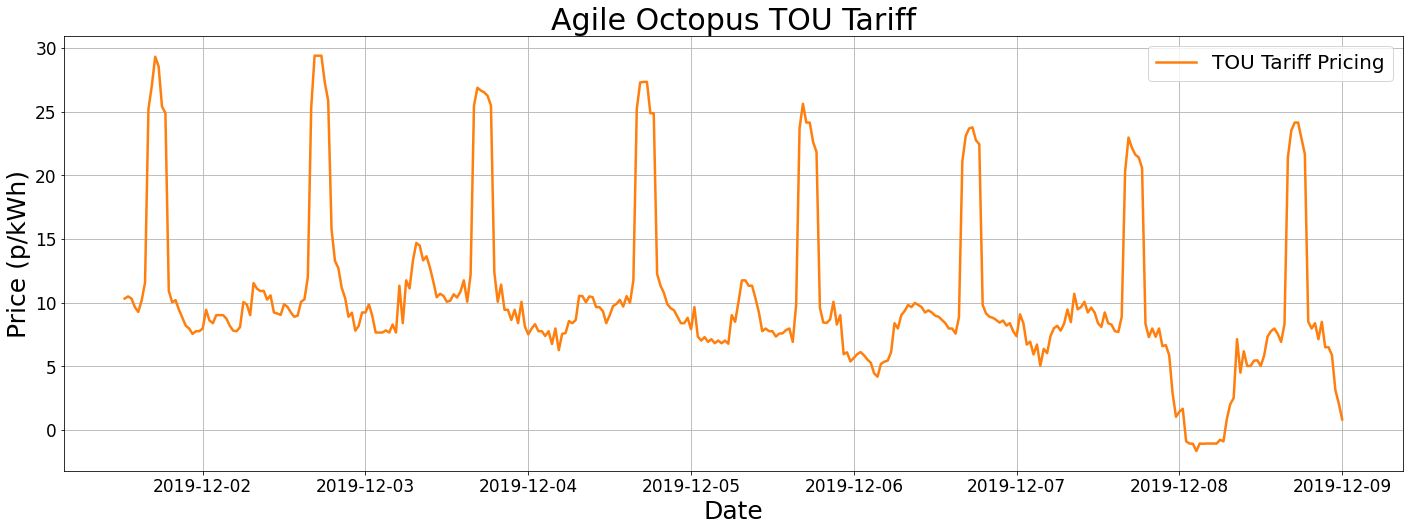

In [ ]:
plt.figure(figsize=(24,8))
plt.grid()
# plt.plot(train['price'], label='Train')
plt.plot(test['price'], label='TOU Tariff Pricing',color='C1', linewidth=2.5)
plt.legend(loc='best', fontsize = 20)
plt.tick_params(axis='x',labelsize=17) #, rotation=45
plt.tick_params(axis='y',labelsize=17)
plt.ylabel("Price (p/kWh)",fontsize=25)
plt.xlabel("Date",fontsize=25)
plt.title('Agile Octopus TOU Tariff',fontsize=30)
# plt.set_major_locator(md.HourLocator(byhour=[0,12]))
# plt.set_major_formatter(md.DateFormatter("%d/%m\n %H:%M"))
plt.show()

This notebook is for baseline models <br> methods we will use are:
- average forecast
- Naive forecast 1
- seasonal Naive
- Naive with Drift
<br>Baseline methods are to ensure, any other complex methods used are better than the baseline, if it worse then dont use 

## Mean

In [ ]:
avg = Average()
avg.fit(data)
print(avg.fit(data))

None


In [ ]:
# start = len(train)
# end = len(train) + len(test) -1
# avg_preds = avg.predict(start=start, end=end)
avg_preds = avg.predict(horizon = 10)

In [ ]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['price'].mean()
print(y_hat_avg.index)

DatetimeIndex(['2019-12-01 12:30:00', '2019-12-01 13:00:00',
               '2019-12-01 13:30:00', '2019-12-01 14:00:00',
               '2019-12-01 14:30:00', '2019-12-01 15:00:00',
               '2019-12-01 15:30:00', '2019-12-01 16:00:00',
               '2019-12-01 16:30:00', '2019-12-01 17:00:00',
               ...
               '2019-12-08 19:30:00', '2019-12-08 20:00:00',
               '2019-12-08 20:30:00', '2019-12-08 21:00:00',
               '2019-12-08 21:30:00', '2019-12-08 22:00:00',
               '2019-12-08 22:30:00', '2019-12-08 23:00:00',
               '2019-12-08 23:30:00', '2019-12-09 00:00:00'],
              dtype='datetime64[ns]', name='date', length=360, freq=None)


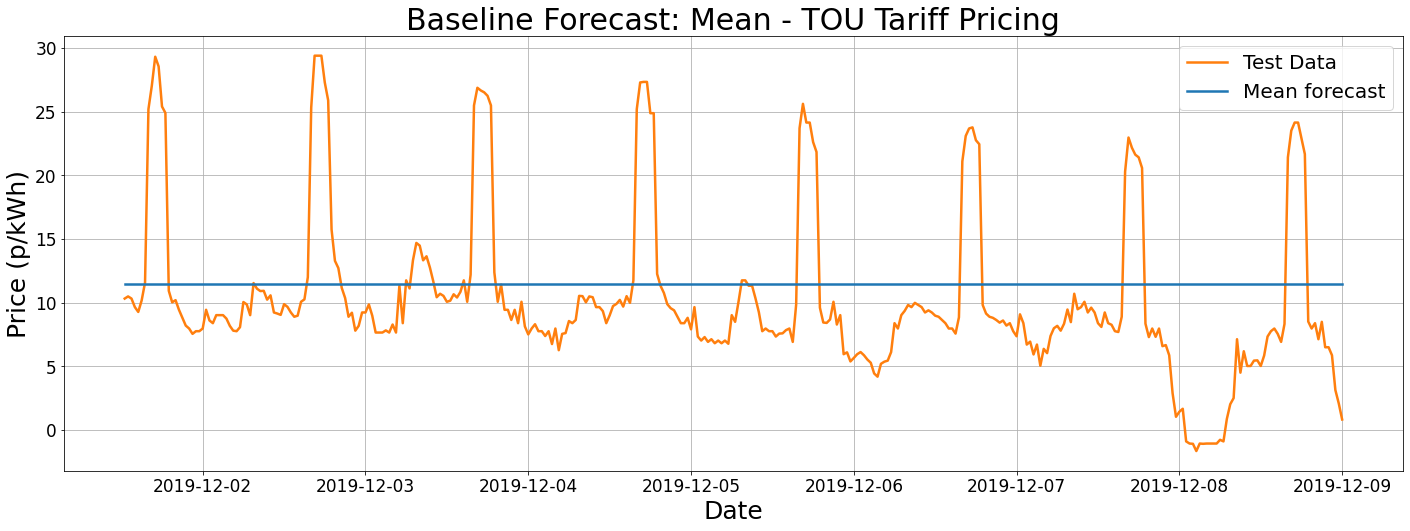

In [ ]:
plt.figure(figsize=(24,8))
plt.grid()
# plt.plot(train['price'], label='Train')
plt.plot(test['price'], label='Test Data',color='C1', linewidth=2.5)
plt.plot(y_hat_avg['avg_forecast'], label='Mean forecast', linewidth=2.5)
plt.legend(loc='best', fontsize = 20)
plt.tick_params(axis='x',labelsize=17) #, rotation=45
plt.tick_params(axis='y',labelsize=17)
plt.ylabel("Price (p/kWh)",fontsize=25)
plt.xlabel("Date",fontsize=25)
plt.title('Baseline Forecast: Mean - TOU Tariff Pricing',fontsize=30)
# plt.set_major_locator(md.HourLocator(byhour=[0,12]))
# plt.set_major_formatter(md.DateFormatter("%d/%m\n %H:%M"))
plt.show()

In [ ]:
print("Baseline Mean Rolling RMSE: ", sqrt(mean_squared_error(y_hat_avg['avg_forecast'],test['price'])))
print("Baseline Mean Rolling MSE: ", mean_squared_error(y_hat_avg['avg_forecast'], test['price']))
print("Baseline Mean Rolling MAE: ", mean_absolute_error(y_hat_avg['avg_forecast'], test['price']))
print("Baseline Mean Rolling MAPE: ", 100*mean_absolute_percentage_error(y_hat_avg['avg_forecast'], test['price']),"%")
# print("Baseline Mean Rolling MAPE: ", 100*mean_percentage_error(y_hat_avg['avg_forecast'], test['price']),"%")

Baseline Mean Rolling RMSE:  6.3866393918766695
Baseline Mean Rolling MSE:  40.789162721870795
Baseline Mean Rolling MAE:  4.79010963228491
Baseline Mean Rolling MAPE:  4166.264179624817 %


# Naive

In [ ]:
nf1 = Naive1()
nf1.fit(data)
nf1_preds = nf1.predict(horizon = 10)

# nf1_preds   #shows last value in time series

In [ ]:
y_hat_naive = test.copy()
y_hat_naive['naive_forecast'] = train['price'][len(train)-1]

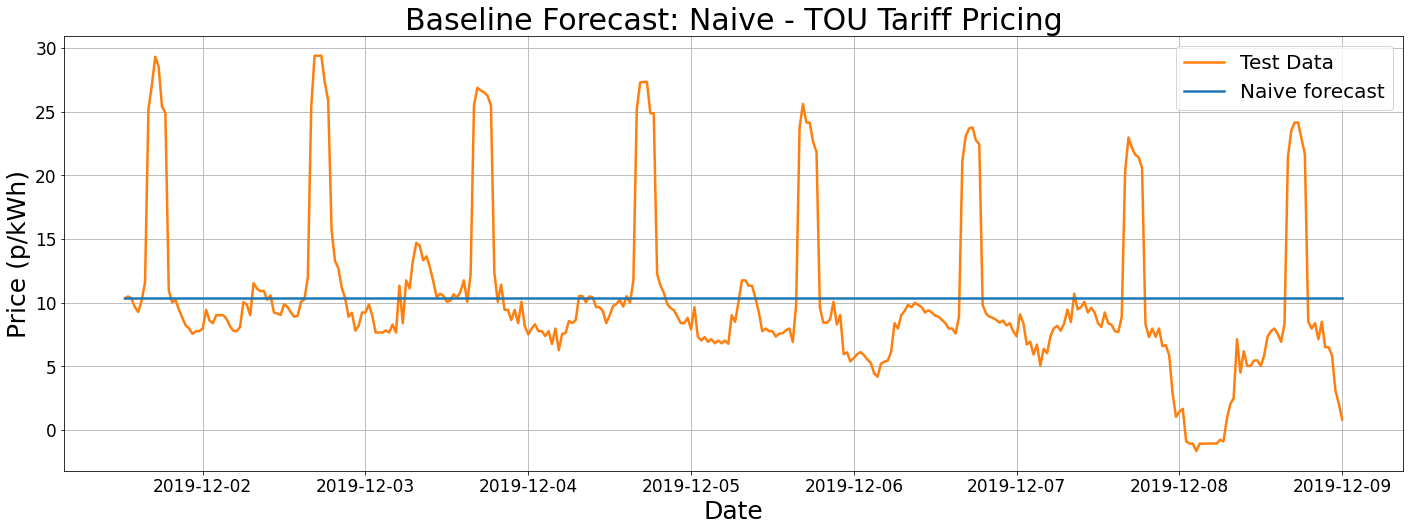

In [ ]:
plt.figure(figsize=(24,8))
plt.grid()
# plt.plot(train['price'], label='Train')
plt.plot(test['price'], label='Test Data',color='C1', linewidth=2.5)
plt.plot(y_hat_naive['naive_forecast'], label='Naive forecast', linewidth=2.5)
plt.legend(loc='best', fontsize = 20)
plt.tick_params(axis='x',labelsize=17) #, rotation=45
plt.tick_params(axis='y',labelsize=17)
plt.ylabel("Price (p/kWh)",fontsize=25)
plt.xlabel("Date",fontsize=25)
plt.title('Baseline Forecast: Naive - TOU Tariff Pricing',fontsize=30)
# plt.set_major_locator(md.HourLocator(byhour=[0,12]))
# plt.set_major_formatter(md.DateFormatter("%d/%m\n %H:%M"))
plt.show()

In [ ]:
print("Baseline Naive Rolling RMSE: ", sqrt(mean_squared_error(y_hat_naive['naive_forecast'],test['price'])))
print("Baseline Naive Rolling MSE: ", mean_squared_error(y_hat_naive['naive_forecast'], test['price']))
print("Baseline Naive Rolling MAE: ", mean_absolute_error(y_hat_naive['naive_forecast'], test['price']))
print("Baseline Naive Rolling MAPE: ", 100*mean_absolute_percentage_error(y_hat_naive['naive_forecast'], test['price']),"%")
# print("Baseline Naive Rolling MAPE: ", 100*mean_percentage_error(y_hat_naive['naive_forecast'], test['price']),"%")

Baseline Naive Rolling RMSE:  6.287539855241476
Baseline Naive Rolling MSE:  39.53315743125
Baseline Naive Rolling MAE:  4.163979166666667
Baseline Naive Rolling MAPE:  4013.860773729194 %


# Seasonal Naive

In [ ]:
data.index.freq = '30t'
data.index.dtype
snf = SNaive(period=48)
snf.fit(train)
# snf_preds = snf.predict(horizon = 48)
snf_preds = snf.predict(horizon = 360)

In [ ]:
y_hat_snaive = test.copy()
y_hat_snaive['snaive_forecast'] = snf_preds.tolist()
y_hat_snaive

,price,snaive_forecast
date,,
2019-12-01 12:30:00,10.332,10.920
2019-12-01 13:00:00,10.500,10.836
2019-12-01 13:30:00,10.332,10.836
2019-12-01 14:00:00,9.660,10.101
2019-12-01 14:30:00,9.282,10.080
...,...,...
2019-12-08 22:00:00,6.510,9.030
2019-12-08 22:30:00,5.880,8.442
2019-12-08 23:00:00,3.150,10.290


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: Unrecognized location '1'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  del sys.path[0]


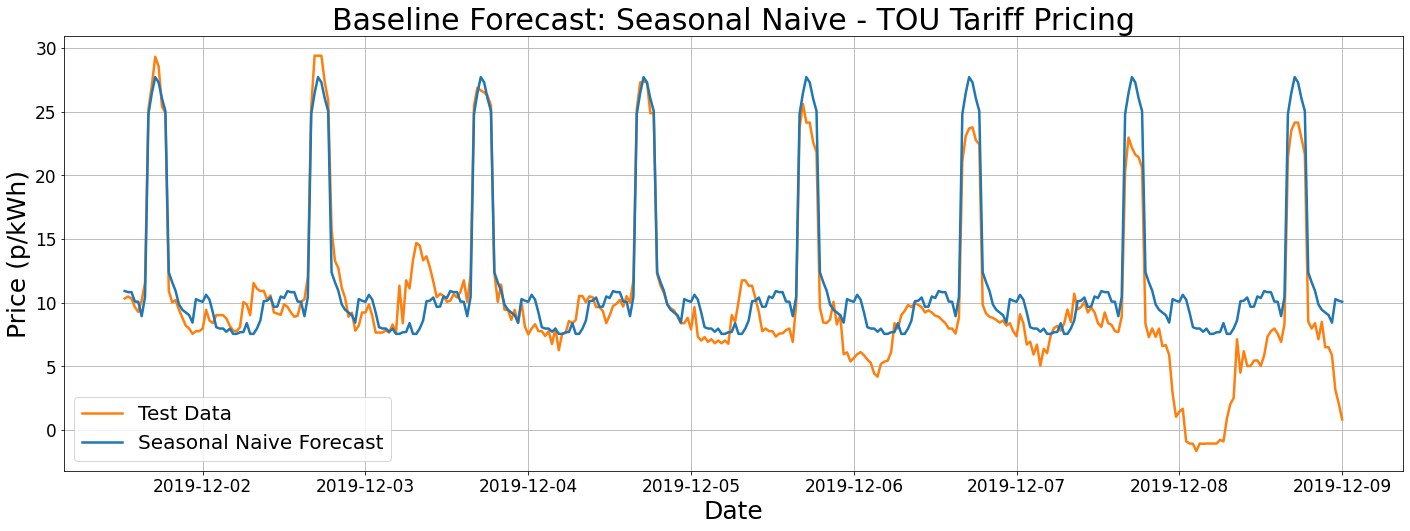

In [ ]:
plt.figure(figsize=(24,8))
plt.grid()
# plt.plot(train['price'], label='Train')
plt.plot(test['price'], label='Test Data',color='C1', linewidth=2.5)
plt.plot(y_hat_snaive['snaive_forecast'], label='Seasonal Naive Forecast', linewidth=2.5)
plt.tick_params(axis='x',labelsize=17) #, rotation=45
plt.tick_params(axis='y',labelsize=17)
plt.ylabel("Price (p/kWh)",fontsize=25)
plt.xlabel("Date",fontsize=25)
plt.title('Baseline Forecast: Seasonal Naive - TOU Tariff Pricing',fontsize=30)
# plt.set_major_locator(md.HourLocator(byhour=[0,12]))
# plt.set_major_formatter(md.DateFormatter("%d/%m\n %H:%M"))
plt.legend(loc='1', fontsize = 20)
plt.show()

In [ ]:
print("Baseline Seasonal Naive Rolling RMSE: ", sqrt(mean_squared_error(y_hat_snaive['snaive_forecast'],test['price'])))
print("Baseline Seasonal Naive Rolling MSE: ", mean_squared_error(y_hat_snaive['snaive_forecast'], test['price']))
print("Baseline Seasonal Naive Rolling MAE: ", mean_absolute_error(y_hat_snaive['snaive_forecast'], test['price']))
print("Baseline Seasonal Naive Rolling MAPE: ", 100*mean_absolute_percentage_error(y_hat_snaive['snaive_forecast'], test['price']),"%")
# print("Baseline Seasonal Naive Rolling MAPE: ", 100*mean_percentage_error(y_hat_snaive['snaive_forecast'], test['price']),"%")

Baseline Seasonal Naive Rolling RMSE:  3.009508942502082
Baseline Seasonal Naive Rolling MSE:  9.057144075
Baseline Seasonal Naive Rolling MAE:  2.1209416666666665
Baseline Seasonal Naive Rolling MAPE:  2100.9703631606358 %


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Unrecognized location '1'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  from ipykernel import kernelapp as app


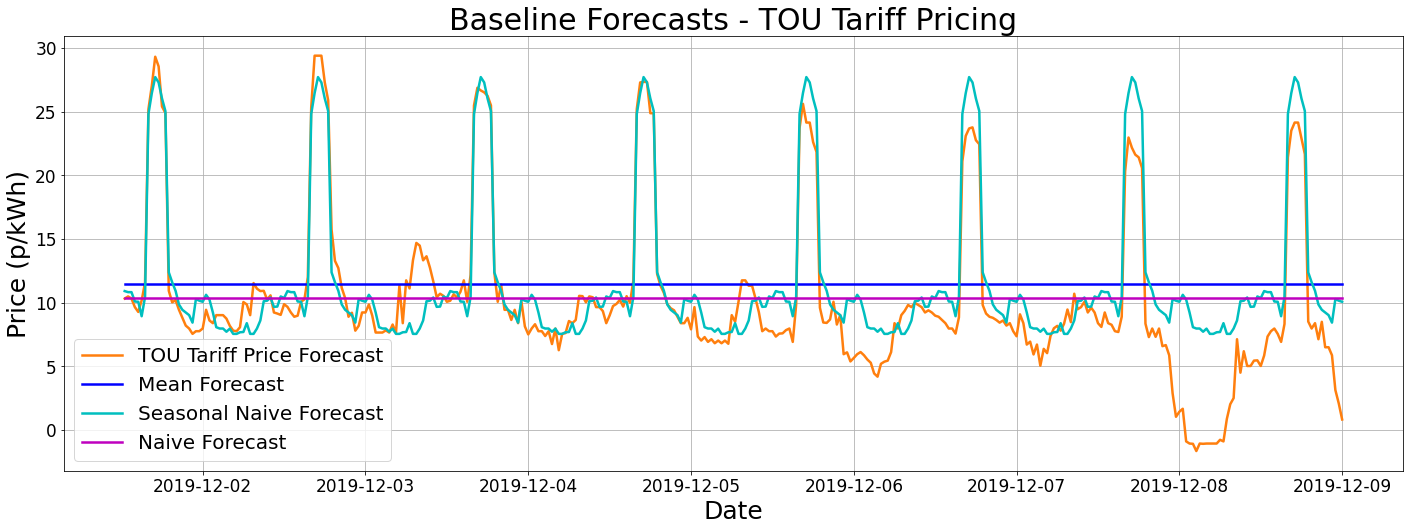

In [ ]:
plt.figure(figsize=(24,8))
plt.grid()
# plt.plot(train['price'], label='Train')
plt.plot(test['price'], label='TOU Tariff Price Forecast',color='C1', linewidth=2.5)
plt.plot(y_hat_avg['avg_forecast'], label='Mean Forecast',color='b', linewidth=2.5)
plt.plot(y_hat_snaive['snaive_forecast'], label='Seasonal Naive Forecast',color='c', linewidth=2.5)
plt.plot(y_hat_naive['naive_forecast'], label='Naive Forecast',color='m', linewidth=2.5)
plt.tick_params(axis='x',labelsize=17) #, rotation=45
plt.tick_params(axis='y',labelsize=17)
plt.ylabel("Price (p/kWh)",fontsize=25)
plt.xlabel("Date",fontsize=25)
plt.title('Baseline Forecasts - TOU Tariff Pricing',fontsize=30)
# plt.set_major_locator(md.HourLocator(byhour=[0,12]))
# plt.set_major_formatter(md.DateFormatter("%d/%m\n %H:%M"))
plt.legend(loc='1', fontsize = 20)
plt.show()

## ARIMA

Arima models are divided into 3 parts:<br><br>
<B>AR:</B> Autoregression. Uses previous values to make future prediction. e.g. second order means using past 2 values<br><br>
<B>I:</B> Integrated. Differencing, If your data is not stationary, you need to difference it with previous values to eliminate trends<br><br>
<B>MA:</B> Moving average. Uses past errors to make a future prediction e.g. moving average of 2 means using past 2 errors<br><br>

#### Finding best ARIMA model

Using auto_arima, it takes into account  AIC (Akaike Information Criterion), which are used for selecting predictors in regression, evaluating how well a model fits the data it was generated from. The better models have lower AIC.

In [ ]:
stepWiseFit = auto_arima(data['price'],trace=True, supress_warnings=True, max_p=50,  max_order=100)
stepWiseFit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=6844.663, Time=3.96 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=9240.444, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=7018.582, Time=0.35 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=7885.044, Time=0.61 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=11417.375, Time=0.06 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=6887.567, Time=1.19 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=6842.959, Time=1.31 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=6912.434, Time=0.77 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=6878.756, Time=0.55 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=6844.770, Time=2.16 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=6856.104, Time=0.90 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=6831.093, Time=3.39 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=6770.306, Time=4.42 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=6799.920, Time=2.33 sec
 ARIMA(5,0,2)(0,0,0)[0] intercep

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1441
Model:               SARIMAX(4, 0, 5)   Log Likelihood               -3233.091
Date:                Sun, 10 Apr 2022   AIC                           6488.182
Time:                        15:54:00   BIC                           6546.186
Sample:                             0   HQIC                          6509.834
                               - 1441                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      8.9592      1.044      8.581      0.000       6.913      11.005
ar.L1          0.2418      0.049      4.907      0.000       0.145       0.338
ar.L2         -0.0865      0.055     -1.568      0.117      -0.195       0.022
ar.L3          0.1019      0.078      1.300      0.194      -0.052       0.256
ar.L4         -0.0573      0.057     -0.998      0.318      -0.170       0.055
ma.L1          0.8949      0.040     22.653      0.000       0.817       0.972
ma.L2          0.9775      0.041     24.121      0.000       0.898       1.057
ma.L3          0.8545      0.043     19.691      0.000       0.769       0.940
ma.L4          0.8070      0.029     28.117      0.000       0.751       0.863
ma.L5          0.6716      0.022     30.815      0.000       0.629       0.714
sigma2         5.1922      0.119     43.798      0.000       4.960       5.425
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             23752.92
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                             3.57
Prob(H) (two-sided):                  0.81   Kurtosis:                        21.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Correlograms

Autocorrelogram & Partail Autocorrelogram is useful that to estimate each models parameters.<br><br>
Autocorrelation refers to how correlated a time series is with its past values.<br><br>
ACF is the plot to see the correlation between points up to and including the lag unit.<br><br>

In [ ]:
acf_values = acf(data['price'])
acf_values

array([ 1.        ,  0.88592815,  0.71955966,  0.5365267 ,  0.35123973,
        0.18476045,  0.04853163,  0.0109512 , -0.01222414, -0.038338  ,
       -0.06072439, -0.08448133, -0.08982941, -0.09522555, -0.09592393,
       -0.10148505, -0.10972994, -0.1166806 , -0.14997976, -0.18126056,
       -0.20905918, -0.23503395, -0.25673856, -0.27425603, -0.27927264,
       -0.27605823, -0.26048037, -0.23969981, -0.21482529, -0.18958048,
       -0.16057405, -0.12934815])

Blue region is the confidence band. Anything within this range represents a value that has no significant correlation with the most recent value for the price. <br><br>
This lets us know that previous prices influence the current price but the significance of that influence decreases steadily with time. Specifically, values beyond the 5th previous day have no significant predictive power on the current price.

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


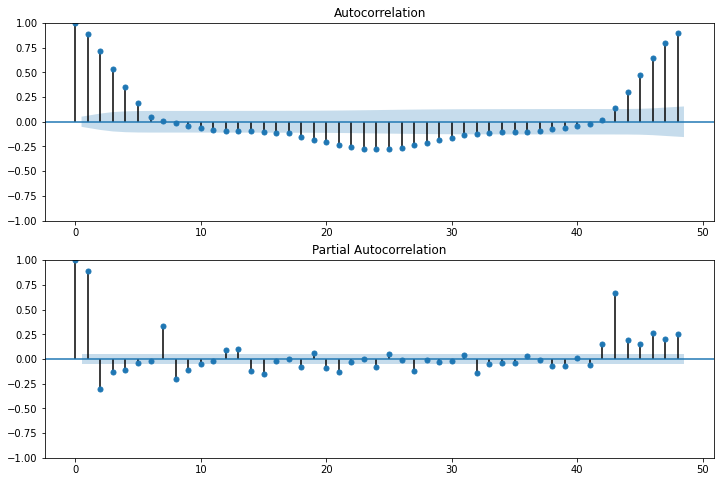

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = smapi.graphics.tsa.plot_acf(data['price'], lags=48, ax=ax1) # 
ax2 = fig.add_subplot(212)
fig = smapi.graphics.tsa.plot_pacf(data['price'], lags=48, ax=ax2)# , lags=40

#### Train test split the data

In [ ]:
data_length = data.shape[0]
split70 = round(data_length*0.75)
train = data.iloc[:split70]
test = data.iloc[split70:]
print(train.shape, test.shape)
print(data_length)

(1081, 1) (360, 1)
1441


In [ ]:
print(train)
print(train.index.dtype)

                      price
date                       
2019-11-09 00:00:00   9.870
2019-11-09 00:30:00  10.080
2019-11-09 01:00:00   8.820
2019-11-09 01:30:00   8.820
2019-11-09 02:00:00   9.660
...                     ...
2019-12-01 10:00:00  10.416
2019-12-01 10:30:00   9.681
2019-12-01 11:00:00   9.702
2019-12-01 11:30:00  10.500
2019-12-01 12:00:00  10.374

[1081 rows x 1 columns]
datetime64[ns]


#### Train the model

In [ ]:
arimamodel = ARIMA(train['price'], order=(24,0,5))
arimamodel = arimamodel.fit()
#arimamodel.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


#### Make predictions on the test set

In [ ]:
start = len(train)
end = len(train) + len(test) -1
arimapred = arimamodel.predict(start=start, end=end, typ='levels')
arimapred

2019-12-01 12:30:00    11.258578
2019-12-01 13:00:00    11.276659
2019-12-01 13:30:00    13.841473
2019-12-01 14:00:00    14.326195
2019-12-01 14:30:00    14.979898
                         ...    
2019-12-08 22:00:00    14.349938
2019-12-08 22:30:00    14.349382
2019-12-08 23:00:00    14.226246
2019-12-08 23:30:00    14.358935
2019-12-09 00:00:00    14.048089
Freq: 30T, Name: predicted_mean, Length: 360, dtype: float64

#### Plot prediction

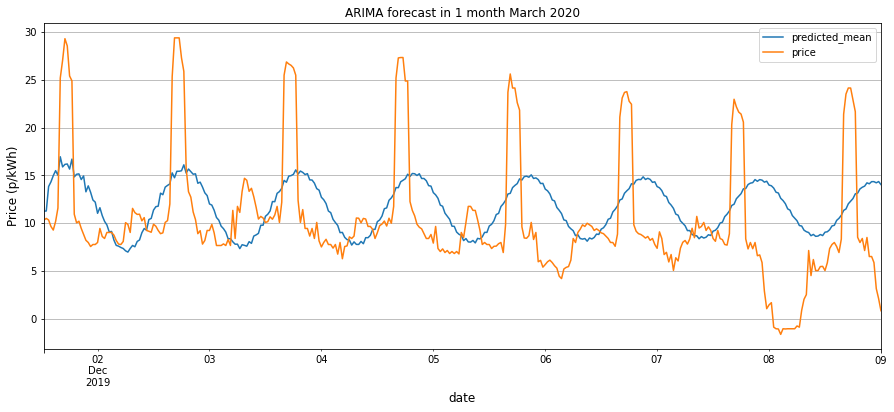

In [ ]:
arimapred.plot(legend = True, figsize=(15,6))
plt.title('ARIMA forecast in 1 month March 2020', fontsize=12)
plt.ylabel("Price (p/kWh)", fontsize=12)
plt.xlabel("Date", fontsize=12)
test['price'].plot(legend = True)
plt.grid()

### Check forecast error

#### RMSE

In [ ]:
print("ARIMA RMSE: ", sqrt(mean_squared_error(arimapred,test['price'])))
print("ARIMA MSE: ", mean_squared_error(arimapred, test['price']))
print("ARIMA MAE: ", mean_absolute_error(arimapred, test['price']))
print("ARIMA MAPE: ", mean_absolute_percentage_error(arimapred, test['price']),"%")
# print("ARIMA MPE: ", 100*mean_percentage_error(arimapred, test['price']),"%")

ARIMA RMSE:  6.388859526160235
ARIMA MSE:  40.81752604500838
ARIMA MAE:  4.795201514620775
ARIMA MAPE:  41.69658882191028 %


# Final observations
ARIMA is not a very good model for predicting seasonal data as it does not support time series with seasonal components

# SARIMA

Seasonal Autoregressive Integrated Moving Average is used to forecast data containing trends and seasonality <br><br>
Along with the 3 hyperparameters (p,d,q) that needed to be configured in ARIMA, SARIMA requires 4 additional hyperparamters: (P,D,Q,m)
1. P: Seasonal autogregressive order
2. D: Seasonal difference order
3. Q: Seasonal moving average order
4. m: Number of time steps for a single seasonal period

In [ ]:
# model = smapi.tsa.statespace.SARIMAX(train['price'], order=(1,0,1), seasonal_order=(1,0,1,48))
model = smapi.tsa.statespace.SARIMAX(train['price'], order=(4,0,5), seasonal_order=(4,0,5,48))

In [ ]:
result = model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [ ]:
start = len(train)
end = len(train) + len(test) -1
sarimapred = result.predict(start=start, end=end, dynamic=True)
sarimapred

2019-12-01 12:30:00    10.338169
2019-12-01 13:00:00    10.419715
2019-12-01 13:30:00    10.284732
2019-12-01 14:00:00    10.173996
2019-12-01 14:30:00    10.257241
                         ...    
2019-12-08 22:00:00     9.232141
2019-12-08 22:30:00     8.396287
2019-12-08 23:00:00     9.003385
2019-12-08 23:30:00     8.994421
2019-12-09 00:00:00     8.473135
Freq: 30T, Name: predicted_mean, Length: 360, dtype: float64

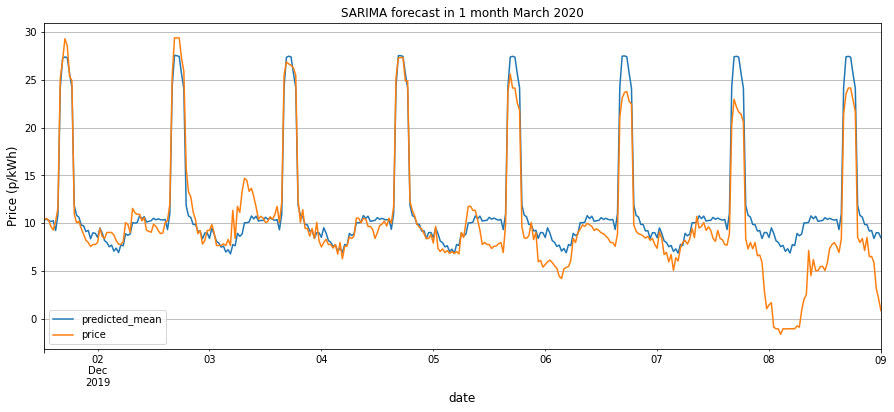

In [ ]:
sarimapred.plot(legend = True, figsize=(15,6))
plt.title('SARIMA forecast in 1 month March 2020', fontsize=12)
plt.ylabel("Price (p/kWh)", fontsize=12)
plt.xlabel("Date", fontsize=12)
test['price'].plot(legend = True)
plt.grid()

In [ ]:
print("SARIMA RMSE: ", sqrt(mean_squared_error(sarimapred,test['price'])))
print("SARIMA MSE: ", mean_squared_error(sarimapred, test['price']))
print("SARIMA MAE: ", mean_absolute_error(sarimapred, test['price']))
print("SARIMA MAPE: ", mean_absolute_percentage_error(sarimapred, test['price']),"%")
# print("SARIMA MAPE: ", 100*mean_percentage_error(sarimapred, test['price']),"%")

SARIMA RMSE:  2.759612569747072
SARIMA MSE:  7.6154615351060375
SARIMA MAE:  1.859135627709692
SARIMA MAPE:  18.270683098676034 %


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Unrecognized location '1'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  


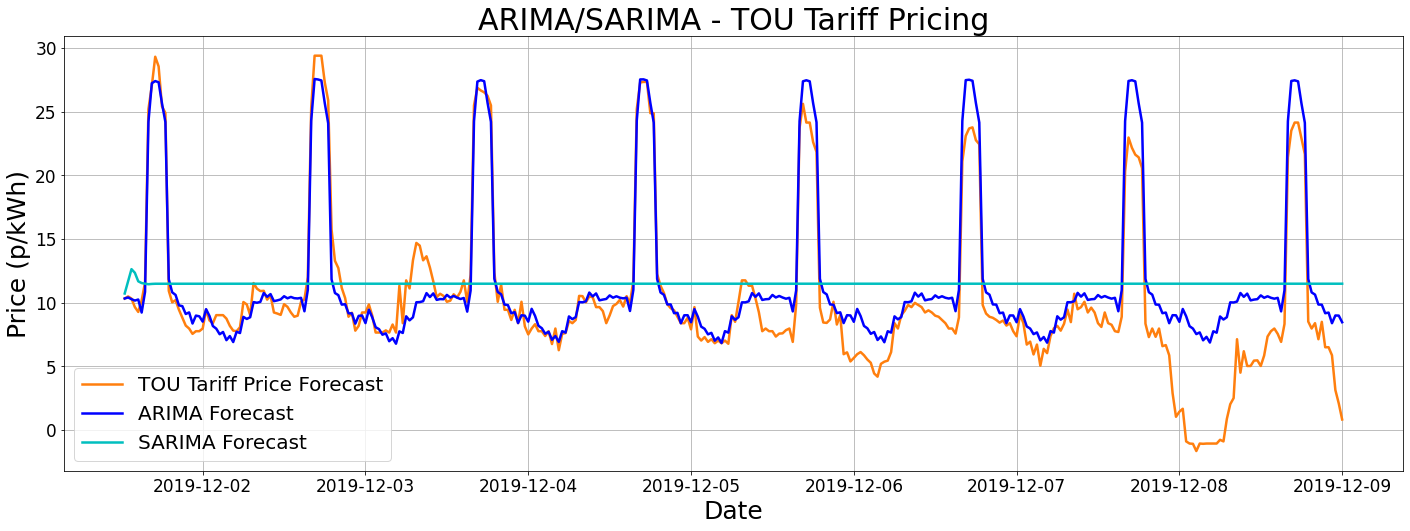

In [ ]:
plt.figure(figsize=(24,8))
plt.grid()
# plt.plot(train['price'], label='Train')
plt.plot(test['price'], label='TOU Tariff Price Forecast',color='C1', linewidth=2.5)
plt.plot(sarimapred, label='ARIMA Forecast',color='b', linewidth=2.5)
plt.plot(arimapred, label='SARIMA Forecast',color='c', linewidth=2.5)
plt.tick_params(axis='x',labelsize=17) #, rotation=45
plt.tick_params(axis='y',labelsize=17)
plt.ylabel("Price (p/kWh)",fontsize=25)
plt.xlabel("Date",fontsize=25)
plt.title('ARIMA/SARIMA - TOU Tariff Pricing',fontsize=30)
# plt.set_major_locator(md.HourLocator(byhour=[0,12]))
# plt.set_major_formatter(md.DateFormatter("%d/%m\n %H:%M"))
plt.legend(loc='1', fontsize = 20)
plt.show()

# FBProphet

In [ ]:
def prophet_format_training_data(data):
    '''
    Convert from Pandas dataframe format to Prophet format
    '''
    prophet_train = pd.DataFrame(data.index)
    prophet_train['y'] = data.to_numpy()
    prophet_train.columns = ['ds','y']    
    
    return prophet_train

In [ ]:
y_train = prophet_format_training_data(data)
y_train['ds'] = y_train['ds'].dt.tz_localize(None) #get rid of timezone
print(y_train['ds'].dtype)
y_train.head()

datetime64[ns]


,ds,y
0,2019-11-09 00:00:00,9.87
1,2019-11-09 00:30:00,10.08
2,2019-11-09 01:00:00,8.82
3,2019-11-09 01:30:00,8.82
4,2019-11-09 02:00:00,9.66


In [ ]:
data_length = data.shape[0]
split70 = round(data_length*0.75)
train = y_train[:split70]
test = y_train[split70:]
print(train.shape, test.shape)
print(data_length)

(1081, 2) (360, 2)
1441


Seasonalities are estimated using a partial Fourier sum. The number of terms in the partial sum (the order) is a parameter that determines how quickly the seasonality can change. This value can be increased when the seasonality needs to fit higher-frequency changes, and generally be less smooth. The Fourier order can be specified for each built-in seasonality when instantiating the model.
<br>Increasing the number of Fourier terms allows the seasonality to fit faster changing cycles, but can also lead to overfitting: N Fourier terms corresponds to 2N variables used for modeling the cycle. - taken from facebook prophet website

In [ ]:
# prophmodel = Prophet(changepoint_prior_scale=0.1, seasonality_prior_scale=0.5) #fit model by instantiating new prophet object
prophmodel = Prophet(changepoint_prior_scale=0.5, seasonality_prior_scale=1, daily_seasonality=48, weekly_seasonality=7) #fit model by instantiating new prophet object
prophmodel.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [ ]:
future = prophmodel.make_future_dataframe(periods=360, freq='30T')
forecast = prophmodel.predict(future)  
#The predict method will assign each row in future a predicted value which it names yhat

Text(0.5, 1.0, 'Prophet Forecast for non random train test split')

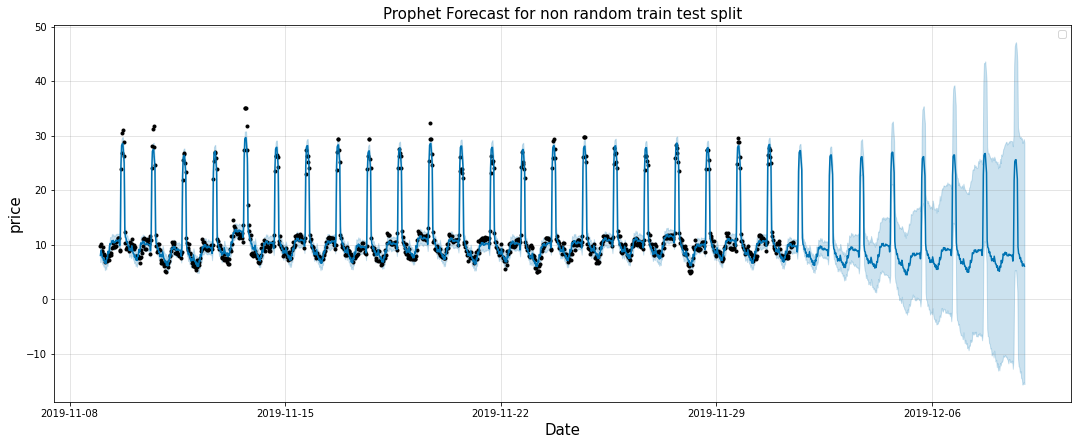

In [ ]:
fig = prophmodel.plot(forecast, figsize=(15,6))
plt.ylabel('price', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.legend()
plt.title('Prophet Forecast for non random train test split', fontsize=15)

In [ ]:
forecast = forecast[-360:]
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1081,2019-12-01 12:30:00,10.395058,8.480695,11.010874,10.395058,10.395058,-0.649323,-0.649323,-0.649323,-1.362255,-1.362255,-1.362255,0.712933,0.712933,0.712933,0.0,0.0,0.0,9.745735
1082,2019-12-01 13:00:00,10.390098,8.622342,11.032629,10.390098,10.390098,-0.539082,-0.539082,-0.539082,-1.432284,-1.432284,-1.432284,0.893203,0.893203,0.893203,0.0,0.0,0.0,9.851016
1083,2019-12-01 13:30:00,10.385137,8.524198,10.886471,10.385137,10.385137,-0.671682,-0.671682,-0.671682,-1.731454,-1.731454,-1.731454,1.059772,1.059772,1.059772,0.0,0.0,0.0,9.713455
1084,2019-12-01 14:00:00,10.380176,8.539814,10.904631,10.380176,10.380176,-0.706012,-0.706012,-0.706012,-1.915624,-1.915624,-1.915624,1.209612,1.209612,1.209612,0.0,0.0,0.0,9.674164
1085,2019-12-01 14:30:00,10.375216,8.656441,11.029072,10.375216,10.375216,-0.577802,-0.577802,-0.577802,-1.917798,-1.917798,-1.917798,1.339995,1.339995,1.339995,0.0,0.0,0.0,9.797414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1436,2019-12-08 22:00:00,8.634025,-14.499024,29.553549,-12.386860,31.080548,-1.647727,-1.647727,-1.647727,-2.032202,-2.032202,-2.032202,0.384475,0.384475,0.384475,0.0,0.0,0.0,6.986297
1437,2019-12-08 22:30:00,8.629064,-15.622822,28.676119,-12.444477,31.149455,-2.520194,-2.520194,-2.520194,-2.696561,-2.696561,-2.696561,0.176367,0.176367,0.176367,0.0,0.0,0.0,6.108870
1438,2019-12-08 23:00:00,8.624103,-15.390366,28.980209,-12.511118,31.218362,-2.137451,-2.137451,-2.137451,-2.102842,-2.102842,-2.102842,-0.034609,-0.034609,-0.034609,0.0,0.0,0.0,6.486652
1439,2019-12-08 23:30:00,8.619143,-15.124066,29.390249,-12.607673,31.297682,-2.116303,-2.116303,-2.116303,-1.871389,-1.871389,-1.871389,-0.244914,-0.244914,-0.244914,0.0,0.0,0.0,6.502839


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Unrecognized location 'Best'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


Text(0.5, 1.0, 'FBProhet Forecast - TOU Tariff Pricing')

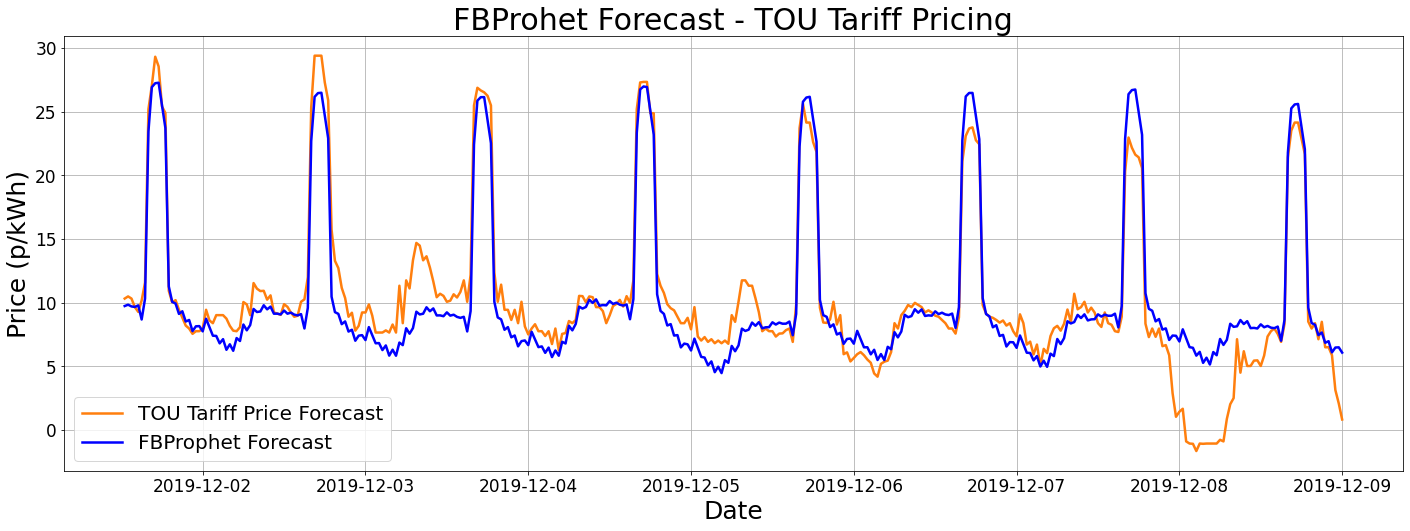

In [ ]:
# ax=forecast.plot(x='ds',y='yhat',legend=True,label='predictions', figsize=(15,6))
# ax=test.plot(x='ds',y='y',legend=True,label='Test Data', figsize=(24,8))
# # test.plot(x='ds',y='y',legend=True,label='True Test Data',ax=ax)
# # ax=train.plot(x='ds',y='y',legend=True,label='Past Data', figsize=(20,8),linewidth=2)
# # test.plot(x='ds',y='y',legend=True,label='Test Data',ax=ax,color='b')
# forecast.plot(x='ds',y='yhat',legend=True,label='Forecasted Data',ax=ax,linewidth=2)
plt.figure(figsize=(24,8))
plt.plot(test['ds'],test['y'], label='TOU Tariff Price Forecast',color='C1', linewidth=2.5)
# plt.plot(train['ds'],train['y'], label='TOU Tariff Price Forecast',color='C1', linewidth=2.5)
plt.plot(forecast['ds'],forecast['yhat'], label='FBProphet Forecast',color='b', linewidth=2.5)

plt.grid()
plt.ylabel("Price (p/kWh)",fontsize=25)
plt.xlabel("Date",fontsize=25)
plt.tick_params(axis='x',labelsize=17)
plt.tick_params(axis='y',labelsize=17)
plt.legend(loc='Best', fontsize = 20)
plt.title('FBProhet Forecast - TOU Tariff Pricing',fontsize=30)

In [ ]:
test.shape[0]
test

,ds,y
1081,2019-12-01 12:30:00,10.332
1082,2019-12-01 13:00:00,10.500
1083,2019-12-01 13:30:00,10.332
1084,2019-12-01 14:00:00,9.660
1085,2019-12-01 14:30:00,9.282
...,...,...
1436,2019-12-08 22:00:00,6.510
1437,2019-12-08 22:30:00,5.880
1438,2019-12-08 23:00:00,3.150
1439,2019-12-08 23:30:00,2.100


In [ ]:
print("Prophet RMSE: ", sqrt(mean_squared_error(forecast['yhat'],test['y'])))
print("Prophet MSE: ", mean_squared_error(forecast['yhat'], test['y']))
print("Prophet MAE: ", mean_absolute_error(forecast['yhat'], test['y']))
print("Prophet MAPE: ", mean_absolute_percentage_error(forecast['yhat'], test['y']), "%")
# print("Prophet MPE: ", 100*mean_percentage_error(forecast['yhat'], test['y']), "%")

Prophet RMSE:  2.322257206292478
Prophet MSE:  5.392878532177343
Prophet MAE:  1.663235271074628
Prophet MAPE:  20.29804727839765 %


In [ ]:
import itertools
import numpy as np
import pandas as pd
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(train)  # Fit model with given params
    #df_cv = cross_validation(m, cutoffs=cutoffs, horizon='30 days', parallel="processes")
    df_cv = cross_validation(m,  initial = '240 hours',horizon = '96 hours')
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

In [ ]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0}


# ARIMA ROLLING FORECAST

In [ ]:
data

,price
date,
2019-11-09 00:00:00,9.87
2019-11-09 00:30:00,10.08
2019-11-09 01:00:00,8.82
2019-11-09 01:30:00,8.82
2019-11-09 02:00:00,9.66
...,...
2019-12-08 22:00:00,6.51
2019-12-08 22:30:00,5.88
2019-12-08 23:00:00,3.15


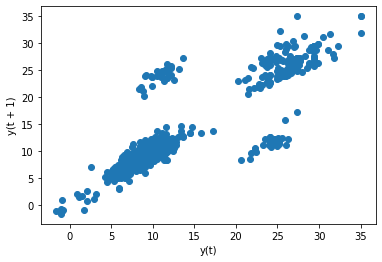

In [ ]:
plt.figure()
lag_plot(data['price'],lag=1)
plt.show()

In [ ]:
data_length = data.shape[0]
split70 = round(data_length*0.75)
train_data = data.iloc[:split70]
test_data = data.iloc[split70:]

training_data = train_data['price'].values  #take the price column values
test_data = test_data['price'].values
history = [x for x in training_data]  #list comprehension to iterate through training_data
model_predictions = []  #instantiate empty list
N_test_observations = len(test_data)  
for t in range(N_test_observations):
    model = smapi.tsa.arima.ARIMA(history, order=(1,0,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[t]
    history.append(true_test_value)

Rolling forecast calculates features then predicts a few ahead, then it shifts the calculated features, and predicts same size window ahead.

DatetimeIndex(['2019-12-01 12:00:00', '2019-12-01 12:30:00',
               '2019-12-01 13:00:00', '2019-12-01 13:30:00',
               '2019-12-01 14:00:00', '2019-12-01 14:30:00',
               '2019-12-01 15:00:00', '2019-12-01 15:30:00',
               '2019-12-01 16:00:00', '2019-12-01 16:30:00',
               ...
               '2019-12-08 19:30:00', '2019-12-08 20:00:00',
               '2019-12-08 20:30:00', '2019-12-08 21:00:00',
               '2019-12-08 21:30:00', '2019-12-08 22:00:00',
               '2019-12-08 22:30:00', '2019-12-08 23:00:00',
               '2019-12-08 23:30:00', '2019-12-09 00:00:00'],
              dtype='datetime64[ns]', name='date', length=361, freq='30T')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Unrecognized location 'Best'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  from ipykernel import kernelapp as app


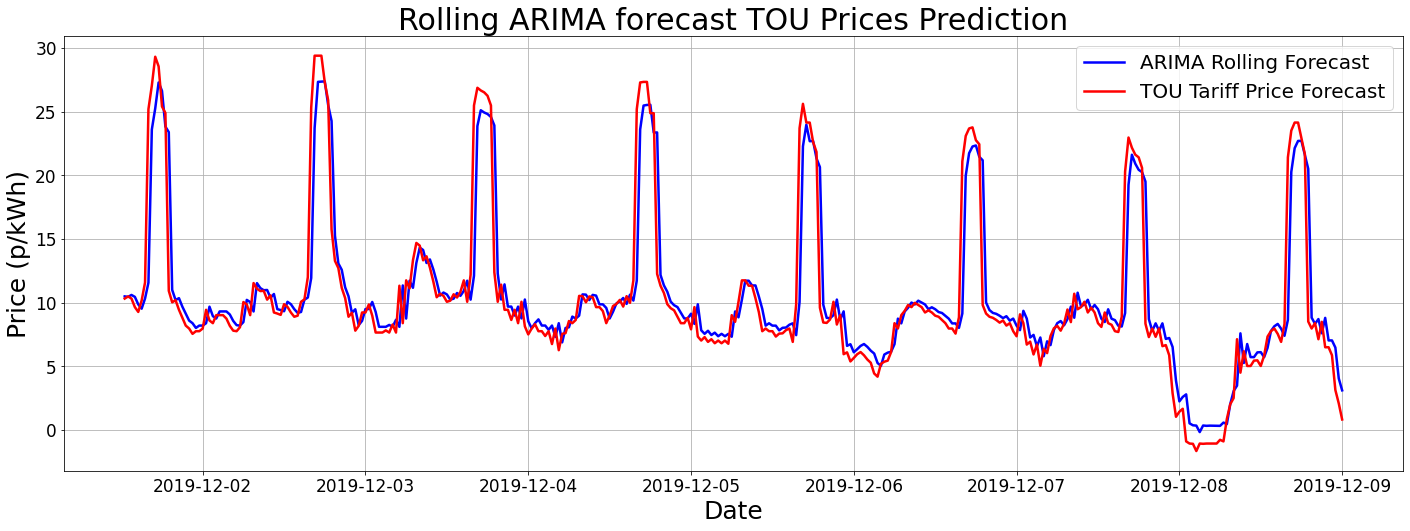

In [ ]:
test_set_range = data[int(len(data)*0.75):].index
#test_set_range = test_set_range[1:]
print(test_set_range)
test_set_range=test_set_range[1:]
plt.figure(figsize=(24,8))
# plt.plot(test_set_range, model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, model_predictions, color='blue',label='ARIMA Rolling Forecast', linewidth=2.5)
plt.plot(test_set_range, test_data, color='red', label='TOU Tariff Price Forecast', linewidth=2.5)
plt.title('Rolling ARIMA forecast TOU Prices Prediction',fontsize=30)
plt.ylabel("Price (p/kWh)",fontsize=25)
plt.xlabel("Date",fontsize=25)
# ax.tick_params(axis='x', which='minor',labelsize=15)
plt.tick_params(axis='x',labelsize=17)
plt.tick_params(axis='y',labelsize=17)
plt.legend(loc='Best', fontsize = 20)
plt.grid()
plt.show()


In [ ]:
print("ARIMA Rolling RMSE: ", sqrt(mean_squared_error(model_predictions,test_data)))
print("ARIMA Rolling MSE: ", mean_squared_error(model_predictions, test_data))
print("ARIMA Rolling MAE: ", mean_absolute_error(model_predictions, test_data))
print("ARIMA Rolling MAPE: ", 100*mean_absolute_percentage_error(model_predictions, test_data),"%")
print("ARIMA Rolling MAPE: ", 100*mean_percentage_error(model_predictions, test_data),"%")

ARIMA Rolling RMSE:  2.8363231055226654
ARIMA Rolling MSE:  8.044728758921737
ARIMA Rolling MAE:  1.439062165083782
ARIMA Rolling MAPE:  2578.4633069806223 %


NameError: ignored

In [ ]:
data_length = data.shape[0]
split70 = round(data_length*0.75)
train = data.iloc[:split70]
test = data.iloc[split70:]

In [ ]:
#arimaRollingPred = pd.DataFrame(list(zip(test.index,model_predictions)), columns =['date', 'arimaRollingPrice'])
#arimaRollingPred['date'] = pd.to_datetime(arimaRollingPred['date'])
arimaRollingPred = pd.Series(model_predictions,index=test.index)
#arimaRollingPred.set_index('date')
# arimaRollingPred = arimaRollingPred.ix[:,:]
arimaRollingPred = arimaRollingPred.squeeze(axis=0)
print(type(arimaRollingPred))
print(arimaRollingPred)


<class 'pandas.core.series.Series'>
date
2019-12-01 12:30:00    10.503566
2019-12-01 13:00:00    10.466332
2019-12-01 13:30:00    10.614647
2019-12-01 14:00:00    10.466095
2019-12-01 14:30:00     9.872091
                         ...    
2019-12-08 22:00:00     7.045951
2019-12-08 22:30:00     7.045345
2019-12-08 23:00:00     6.485764
2019-12-08 23:30:00     4.061486
2019-12-09 00:00:00     3.126501
Length: 360, dtype: float64


In [ ]:
print(type(sarimapred))
print(sarimapred)

<class 'pandas.core.series.Series'>
2019-12-01 12:30:00    10.225563
2019-12-01 13:00:00    10.382410
2019-12-01 13:30:00    10.297393
2019-12-01 14:00:00    10.223135
2019-12-01 14:30:00    10.285574
                         ...    
2019-12-08 22:00:00     9.246581
2019-12-08 22:30:00     8.423238
2019-12-08 23:00:00     9.131262
2019-12-08 23:30:00     9.103988
2019-12-09 00:00:00     8.581827
Freq: 30T, Name: predicted_mean, Length: 360, dtype: float64


In [ ]:
test_set_range = data[int(len(data)*0.75):].index
test_set_range=test_set_range[1:]
test_set_range

DatetimeIndex(['2019-12-01 12:30:00', '2019-12-01 13:00:00',
               '2019-12-01 13:30:00', '2019-12-01 14:00:00',
               '2019-12-01 14:30:00', '2019-12-01 15:00:00',
               '2019-12-01 15:30:00', '2019-12-01 16:00:00',
               '2019-12-01 16:30:00', '2019-12-01 17:00:00',
               ...
               '2019-12-08 19:30:00', '2019-12-08 20:00:00',
               '2019-12-08 20:30:00', '2019-12-08 21:00:00',
               '2019-12-08 21:30:00', '2019-12-08 22:00:00',
               '2019-12-08 22:30:00', '2019-12-08 23:00:00',
               '2019-12-08 23:30:00', '2019-12-09 00:00:00'],
              dtype='datetime64[ns]', name='date', length=360, freq='30T')

Text(0.5, 1.0, 'TOU Tariff Forecast')

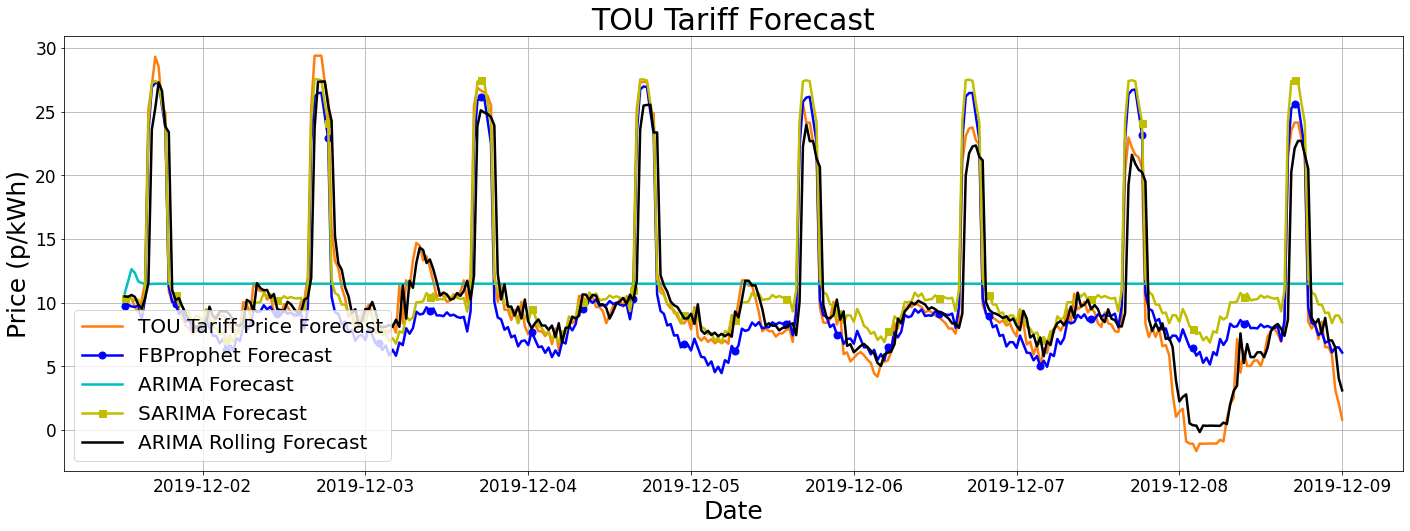

In [ ]:
plt.figure(figsize=(24,8))
plt.plot(test['ds'],test['y'], label='TOU Tariff Price Forecast',color='C1', linewidth=2.5)
# plt.plot(train['ds'],train['y'], label='TOU Tariff Price Forecast',color='C1', linewidth=2.5)
plt.plot(forecast['ds'],forecast['yhat'], label='FBProphet Forecast',color='b', linewidth=2.5, marker='o',markevery=15,markersize=7)
plt.plot(arimapred, label='ARIMA Forecast',color='c', linewidth=2.5)

plt.plot(sarimapred, label='SARIMA Forecast',color='y', linewidth=2.5, marker='s',markevery=15,markersize=7)

# plt.plot(test_set_range, model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, model_predictions, 'k',label='ARIMA Rolling Forecast', linewidth=2.5)
#plt.plot(test['price'], label='TOU Tariff Price Forecast',color='C1', linewidth=2.5)

plt.grid()
plt.ylabel("Price (p/kWh)",fontsize=25)
plt.xlabel("Date",fontsize=25)
plt.tick_params(axis='x',labelsize=17)
plt.tick_params(axis='y',labelsize=17)
plt.legend(loc='lower left', fontsize = 20)
plt.title('TOU Tariff Forecast',fontsize=30)

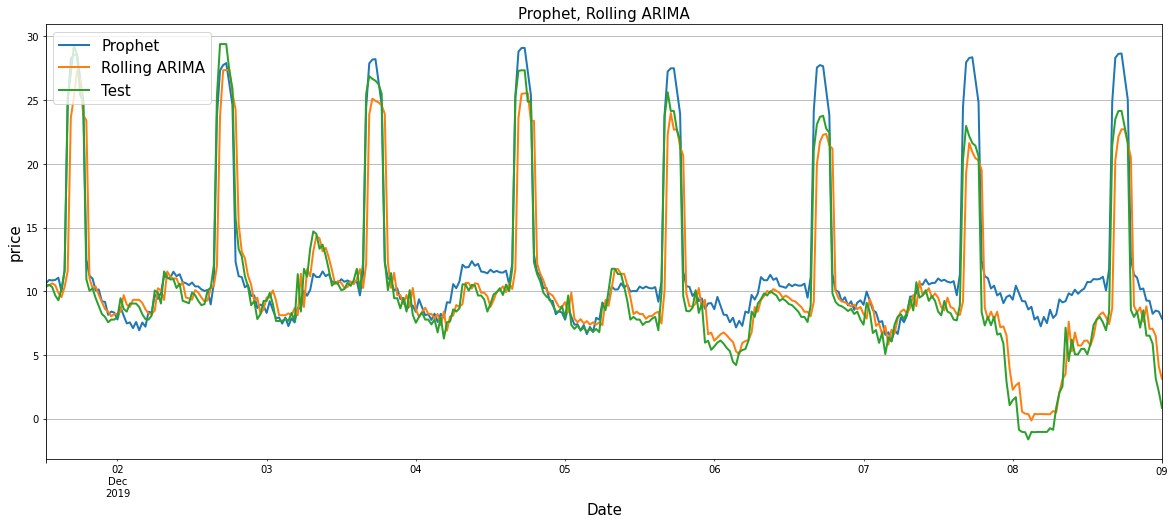

In [ ]:
ax=forecast.plot(x='ds',y='yhat', figsize=(20,8),linewidth=2)
# sarimapred.plot(linewidth=2)
# arimapred.plot(linewidth=2)
arimaRollingPred.plot(linewidth=2)
# plt.plot(test_set_range, model_predictions, color='blue',label='Predicted Price')
#plt.plot(test['price'],model_predictions)
#test.plot(x='ds',y='y')
test['price'].plot(legend = True,linewidth=2)
plt.ylabel('price', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.title('Prophet, Rolling ARIMA', fontsize=15)
plt.legend(['Prophet','Rolling ARIMA','Test'], loc=2, fontsize=15)
plt.grid()

-3.0


NameError: ignored

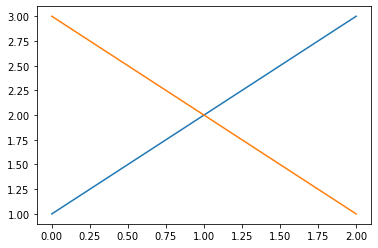

In [ ]:
y_true = [1, 2, 3]
ssr=4+4
sstot=1+1
y_pred = [3, 2, 1]
plt.plot(y_true)
plt.plot(y_pred)
print(1-ssr/sstot)
r2_score(y_true, y_pred)

# ARIMA CROSS VALIDATION

# LSTM

In [ ]:
scaler = MinMaxScaler()

In [ ]:
data

,price
date,
2019-11-09 00:00:00,9.87
2019-11-09 00:30:00,10.08
2019-11-09 01:00:00,8.82
2019-11-09 01:30:00,8.82
2019-11-09 02:00:00,9.66
...,...
2019-12-08 22:00:00,6.51
2019-12-08 22:30:00,5.88
2019-12-08 23:00:00,3.15


In [ ]:
# n=1300
# data.drop(data.tail(n).index,
#         inplace = True)

In [ ]:
data

,price
date,
2019-11-09 00:00:00,9.87
2019-11-09 00:30:00,10.08
2019-11-09 01:00:00,8.82
2019-11-09 01:30:00,8.82
2019-11-09 02:00:00,9.66
...,...
2019-12-08 22:00:00,6.51
2019-12-08 22:30:00,5.88
2019-12-08 23:00:00,3.15


In [ ]:
data_length = data.shape[0]
split70 = round(data_length*0.75)
train = data.iloc[:split70]
test = data.iloc[split70:]

In [ ]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [ ]:
scaled_train[:10]

array([[0.16707275],
       [0.17403411],
       [0.13226592],
       [0.13226592],
       [0.16011138],
       [0.10720501],
       [0.1183432 ],
       [0.06961364],
       [0.0974591 ],
       [0.07657501]])

In [ ]:
as

In [ ]:
n_input = 480
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=48)

In [ ]:
X,y = generator[0]
print(f'given the array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

given the array: 
[0.16707275 0.17403411 0.13226592 ... 0.16707275 0.13226592 0.14618865]
Predict this y: 
 [[0.09328228]
 [0.14479638]
 [0.1127741 ]
 [0.08771319]
 [0.10372433]
 [0.08771319]
 [0.10442047]
 [0.08701706]
 [0.09049774]
 [0.08701706]
 [0.08701706]
 [0.08701706]
 [0.1051166 ]
 [0.14061956]
 [0.19909502]
 [0.25757048]
 [0.2464323 ]
 [0.23459798]
 [0.24573616]
 [0.23250957]
 [0.23250957]
 [0.2158023 ]
 [0.20884093]
 [0.2158023 ]
 [0.22276366]
 [0.22067525]
 [0.20884093]
 [0.20187957]
 [0.22276366]
 [0.22972503]
 [0.22485207]
 [0.27567003]
 [0.67873303]
 [0.91193874]
 [0.81447964]
 [0.81447964]
 [0.72258963]
 [0.65436826]
 [0.24782457]
 [0.18795684]
 [0.20187957]
 [0.14479638]
 [0.14410024]
 [0.14270797]
 [0.16707275]
 [0.13226592]
 [0.14618865]
 [0.1413157 ]]


In [ ]:
X.shape

(48, 480, 1)

In [ ]:
n_input=480
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=48)

In [ ]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(generator, epochs=50)

Epoch 1/50
13/13 [==============================] - 12s 663ms/step - loss: 0.0491
Epoch 2/50
13/13 [==============================] - 7s 526ms/step - loss: 0.0295
Epoch 3/50
13/13 [==============================] - 5s 357ms/step - loss: 0.0260
Epoch 4/50
13/13 [==============================] - 5s 425ms/step - loss: 0.0236
Epoch 5/50
13/13 [==============================] - 8s 635ms/step - loss: 0.0215
Epoch 6/50
13/13 [==============================] - 7s 550ms/step - loss: 0.0191
Epoch 7/50
13/13 [==============================] - 7s 501ms/step - loss: 0.0169
Epoch 8/50
13/13 [==============================] - 4s 344ms/step - loss: 0.0150
Epoch 9/50
13/13 [==============================] - 5s 352ms/step - loss: 0.0135
Epoch 10/50
13/13 [==============================] - 5s 348ms/step - loss: 0.0122
Epoch 11/50
13/13 [==============================] - 5s 346ms/step - loss: 0.0119
Epoch 12/50
13/13 [==============================] - 5s 347ms/step - loss: 0.0103
Epoch 13/50
13/13 [=====

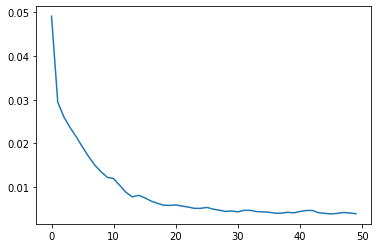

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:
last_train_batch = scaled_train[-1:]

In [ ]:
last_train_batch = last_train_batch.reshape((48, n_input, n_features))

ValueError: ignored

In [ ]:
model.predict(last_train_batch)

In [ ]:
scaled_test[0]

In [ ]:
test_predictions = []
first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1,n_input, n_features))

for i in range(len(test)):
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
test_predictions

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
test['Predictions'] = true_predictions

In [ ]:
test.plot(figsize=(12,6))

In [ ]:
rmse=sqrt(mean_squared_error(test['price'],test['Predictions']))
rmse

# LSTM 2.0

In [ ]:
data

In [ ]:
training_set = data.iloc[:1042].values
test_set = data.iloc[1042:].values

In [ ]:
training_set

### Input features with time lag of 1 second?

In [ ]:
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set)

X_train = []
Y_train = []
for i in range(60,1042):
  X_train.append(training_set_scaled[i-60:i,0])
  Y_train.append(training_set_scaled[i,0])

X_train, Y_train = np.array(X_train), np.array(Y_train)

X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1], 1))

In [ ]:
X_train.shape

In [ ]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, Y_train, epochs = 100, batch_size = 32)

In [ ]:
# Getting the predicted stock price of 2017
dataset_train = data.iloc[:1042]
dataset_test = data.iloc[1042:]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 519):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)
# (459, 60, 1)

In [ ]:
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [ ]:
predicted_stock_price.shape

In [ ]:
# Visualising the results
#plt.plot(data.loc[800:, ‘date’],dataset_test.values, color = ‘red’, label = ‘Real ’)
#plt.plot(data.loc[800:, ‘date’],predicted_stock_price, color = ‘blue’, label = ‘Predicted ’)
plt.figure(figsize=(15, 8))
plt.plot(predicted_stock_price)
plt.plot(dataset_test.values)
plt.xticks(np.arange(0,459,50))
plt.title('')
plt.xlabel('Time')
plt.ylabel('')
plt.legend()
plt.show()

In [ ]:
dataset_test['price'].iloc[:459]

In [ ]:
# print("Prophet RMSE: ", sqrt(mean_squared_error(forecast['yhat'],test['y'])))
# print("Prophet MSE: ", mean_squared_error(forecast['yhat'], test['y']))
# print("Prophet MAE: ", mean_absolute_error(forecast['yhat'], test['y']))
print("Prophet R2 Score: ", r2_score(predicted_stock_price, dataset_test['price'].iloc[:459].values))
# print("R2 Score (Accuracy Metric): ", round(r2_score(forecast['yhat'], test['y']),3)*100,"%")
# print("Prophet Accuracy: ", score(forecast['yhat'], test['y']))

In [ ]:
X_train = []
Y_train = []
for i in range(60, 800):
    X_train.append(training_set_scaled[i-60:i, 0])
    Y_train.append(training_set_scaled[i, 0])

In [ ]:
X_test = []
Y_test = []
for i in range(60, 519):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
X_train = []
Y_train = []
for i in range(60, 800):
    X_train.append(training_set_scaled[i-50:i, 0])
    Y_train.append(training_set_scaled[i, 0])

In [ ]:
X_test = []
Y_test = []
for i in range(60, 519):
    X_test.append(inputs[i-50:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# LSTM 3


In [ ]:
data

In [ ]:
dataset = data.values

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(data)

In [ ]:
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

In [ ]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [ ]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [ ]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

In [ ]:
trainY

In [ ]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

In [ ]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# PLOT TOU FOR PROJECT REPORT

In [ ]:
TOUdata = pd.read_csv('/content/drive/MyDrive/forecasting/TOU-November-2018.csv', parse_dates=True,dayfirst=True)
#TOUdata['date']=pd.to_datetime(Housedata['date'],dayfirst=True)
TOUdate = TOUdata['date']
TOUprice = TOUdata['price']

# dropTOU= 480 #9 days matching EV
#dropTOU= 48 #1 days matching EV
# dropTOU= 96 #2 days matching EV
dropTOU= 336 #2 days matching EV
TOUdate=TOUdate.drop(TOUdate.index[dropTOU:1442]) 
TOUprice=TOUprice.drop(TOUprice.index[dropTOU:1442])
TOUdate=pd.to_datetime(TOUdate,dayfirst=True)

fig=plt.figure(figsize=(24,8))
ax=fig.add_subplot(111, label="1")
# frequencyHouse = round(len(EVdata)/77)
# plt.xticks(np.arange(0,len(EVdata),frequencyHouse),fontsize=10)    

ax.plot(TOUdate, TOUprice, linewidth=2.5, label='TOU Tariff', ls='-')#, ls='-',marker='s',markevery=35000
# ax.plot(TOUdate, moving_average, linewidth=2.5, label='30 Minute Moving Average', ls='-')#, ls='-',marker='s',markevery=35000
# ax.plot(t_filter,p_filter, linewidth=2, label='Fridge', ls='-')#, ls='-',marker='s',markevery=35000


ax.set_xlabel("DateTime",fontsize=25)
ax.set_ylabel("Power (W)",fontsize=25)
#ax.axhline(300,color='limegreen',linewidth=1.5,label='Classifier Threshold')
ax.tick_params(axis='x',labelsize=17) #, rotation=45
ax.tick_params(axis='y',labelsize=17)
ax.xaxis.labelpad = 20
ax.grid()
#ax.get_xaxis().set_visible(False)

lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc=2, fontsize = 20)
ax.xaxis.set_major_locator(md.HourLocator(byhour=[0,12]))
ax.xaxis.set_major_formatter(md.DateFormatter("%d/%m\n %H:%M"))
#ax.xlim(left=0,right=0)
plt.title('Agile Octopus TOU tariff, 09/11/17-16/11/17',fontsize=30)
#plt.show()

In [ ]:
TOUdata = pd.read_csv('/content/drive/MyDrive/forecasting/csv_agile_C_London.csv', parse_dates=True,dayfirst=True)
#TOUdata['date']=pd.to_datetime(Housedata['date'],dayfirst=True)
TOUdate = TOUdata['date']
TOUprice = TOUdata['price']

# dropTOU= 480 #9 days matching EV
#dropTOU= 48 #1 days matching EV
# dropTOU= 96 #2 days matching EV
#dropTOU= 336 #2 days matching EV
TOUdate=TOUdate.drop(TOUdate.index[dropTOU:1442]) 
TOUprice=TOUprice.drop(TOUprice.index[dropTOU:1442])
TOUdate=pd.to_datetime(TOUdate,dayfirst=True)

fig=plt.figure(figsize=(24,8))
ax=fig.add_subplot(111, label="1")
# frequencyHouse = round(len(EVdata)/77)
# plt.xticks(np.arange(0,len(EVdata),frequencyHouse),fontsize=10)    

ax.plot(TOUdate, TOUprice, linewidth=2.5, label='TOU Tariff', ls='-')#, ls='-',marker='s',markevery=35000
# ax.plot(TOUdate, moving_average, linewidth=2.5, label='30 Minute Moving Average', ls='-')#, ls='-',marker='s',markevery=35000
# ax.plot(t_filter,p_filter, linewidth=2, label='Fridge', ls='-')#, ls='-',marker='s',markevery=35000


ax.set_xlabel("DateTime",fontsize=25)
ax.set_ylabel("Power (W)",fontsize=25)
#ax.axhline(300,color='limegreen',linewidth=1.5,label='Classifier Threshold')
ax.tick_params(axis='x',labelsize=17) #, rotation=45
ax.tick_params(axis='y',labelsize=17)
ax.xaxis.labelpad = 20
ax.grid()
#ax.get_xaxis().set_visible(False)

lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc=2, fontsize = 20)
ax.xaxis.set_major_locator(md.HourLocator(byhour=[0,12]))
ax.xaxis.set_major_formatter(md.DateFormatter("%d/%m\n %H:%M"))
#ax.xlim(left=0,right=0)
plt.title('Agile Octopus TOU tariff, 09/11/17-16/11/17',fontsize=30)
#plt.show()

In [ ]:
TOUdata = pd.read_csv('/content/drive/MyDrive/forecasting/csv_agile_C_London.csv', parse_dates=True,dayfirst=True)


TOUdata.columns = ['Date','Price'] # Naming columns

date = TOUdata['Date']
# time_of_day = TOUdata['Time']
price = TOUdata['Price']

date=date.drop(date.index[0:479])
# time_of_day=time_of_day.drop(time_of_day.index[0:479])
price=price.drop(price.index[0:479])

#print(date,price)

# Format date with date and time, time having newlined
date=date.apply(str)    #turn panda column into string
date=date.str.replace(' ','\n')
date=date.str.replace('Z','')

# rows=66478
# date_reduce=date.head(rows)
# price_reduce=price.head(rows)
# #reduce number of values to hourly
# months = ['01/03/18', '01/04/18', '01/05/18', '01/06/18', '01/07/18', '01/08/18', '01/09/18', '01/10/18', '01/11/18', '01/12/18'
#           , '01/01/19', '01/02/19', '01/03/19', '01/04/19', '01/05/19', '01/06/19', '01/07/19', '01/08/19', '01/09/19', '01/10/19'
#           , '01/11/19', '01/12/19', '01/01/20', '01/02/20', '01/03/20', '01/04/20', '01/05/20', '01/06/20', '01/07/20', '01/08/20'
#           , '01/09/20', '01/10/20', '01/11/20', '01/12/20', '01/01/21', '01/02/21', '01/03/21', '01/04/21', '01/05/21', '01/06/21'
#           , '01/07/21', '01/08/21', '01/09/21', '01/10/21', '01/11/21', '01/12/21', '01/01/22', '01/02/22']
months = ['01/03/18', '01/05/18', '01/07/18', '01/09/18', '01/11/18', '01/01/19', '01/03/19','01/05/19', 
          '01/07/19','01/09/19', '01/11/19','01/01/20', 
          '01/03/20', '01/05/20',  '01/07/20', '01/09/20', '01/11/20', '01/01/21',  '01/03/21',  '01/05/21', '01/07/21'
          , '01/09/21', '01/11/21', '01/01/22']
price_tick = ['-10', '-5', '0', '5', '10', '15', '20', '25', '30', '35' ]
#Plot date vs price
plt.figure(figsize=(24,8))
# plt.plot(date_reduce,price_reduce,linewidth=0.5)    
# plt.xticks(np.arange(0,len(date_reduce),frequency),fontsize=7)      #change tick frequency, starting from 0, to length of array, taking every 'frequency' steps
plt.plot(date,price,linewidth=0.5)    
#plt.xticks(np.arange(0,len(date),frequency),fontsize=7)      #change tick frequency, starting from 0, to length of array, taking every 'frequency' steps
# plt.xticks(np.linspace(0,65998,48), months,fontsize=13,rotation=45)
plt.xticks(np.linspace(0,68159,24), months,fontsize=17,rotation=30)
plt.yticks(np.linspace(-10,35,10), price_tick,fontsize=17)
plt.ylabel("Price (p/kWh)",fontsize=25)
plt.xlabel("Date (DD/MM/YY)",fontsize=25)
plt.grid()
plt.title('Octopus Energy Agile Tariff from 01/03/18 to Present 08/01/22',fontsize=30)
#plt.show()